# 🙋 **Pomysły**
- w okolicach wartości optymalnych wygenerować przedziały i przetestować ich kombinacje z pozostałymi parametrami

# 🔥 **Importy**

In [64]:
from our_library.our_reusable_methods import *

import pandas as pd
import seaborn as sns
import itertools

from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,Lars
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split,HalvingGridSearchCV,HalvingRandomSearchCV,GridSearchCV
from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")

# 🟢 **Tematyka projektu**
1. Stworzenie modelu regresji do przewidywania ilości spożywanego przez młodzież alkoholu zależnie od czynników środowiskowych.
2. Skorzystano ze zbioru [student-alcohol-consumption](https://data.world/data-society/student-alcohol-consumption)
3. Oryginalny zbiór zawiera dane z podziałem na szkoły i 2 tabele posiadają dane na temat ocen z matematyki oraz języka. Połączono obie tabelki w jedną i usunięto niepotrzebne kolumny. Zmienne opisywane to spożycie w tygodniu oraz w weekendy. Połączono obie zmienne w jedną we wspólny współczynnik patologicznego spożycia, gdzie picie w tygodniu będzie liczone z wyższą wagą.

# 🟠 **Przygotowanie Danych**

In [4]:
# wczytanie zbioru i usunięcie niepotrzebnych nam kolumn
d1 = pd.read_csv("student-mat.csv")
d2 = pd.read_csv("student-por.csv")
# łączę obie tabelki w jedną
dataset = pd.concat([d1,d2], ignore_index=True)
# istnieje część wspólna obu tabelek więc usuwam kolumny niepotrzebne i z założenia różniące obie tabele i usuwam duplikaty, czyli wystąpienia tych samych uczniów
dataset = dataset.drop(columns=["G1","G2","G3","paid"]).drop_duplicates(ignore_index=True)
# zakładam, że picie w tygodniu dwukrotnie mocniej wskazuje na problem alkoholowy
dataset['alc'] = 2 * dataset.Dalc + dataset.Walc
# usuwam kolejne zbędne kolumny
dataset = dataset.drop(columns=["school","Dalc","Walc"])
# usunięcie rekordów z brakami
dataset = dataset.dropna()
# prosta binaryzacja atrybutów tam gdzie to możliwe, 
# dobieram wartości tak, aby rosły wraz ze stopniem depresji
dataset.sex = dataset.sex.apply(lambda x:0 if x=="F" else 1)
dataset.address = dataset.address.apply(lambda x:0 if x=="R" else 1)
dataset.famsize = dataset.famsize.apply(lambda x:0 if x=="LE3" else 1)
dataset.Pstatus = dataset.Pstatus.apply(lambda x:0 if x=="T" else 1)
# zamiast pisać ręcznie dla każdej jak powyżej
yes_no_columns = ['schoolsup','famsup','activities','nursery','higher','internet','romantic']
for c in yes_no_columns:
    dataset[c] = dataset[c].apply(lambda x:0 if x=="no" else 1)
# binaryzacja techniką one-hot-encode atrybytów kategorycznych
features_to_encode = ['Mjob','Fjob','reason','guardian']
encoder = OneHotEncoder()
results = encoder.fit_transform(dataset.loc[:,features_to_encode])
# zamiana starych atr. kat. na nowe one-hot-y
dataset_without_categoricals = dataset.drop(columns=features_to_encode).reset_index().drop(columns=["index"])
encoded_categoricals = pd.DataFrame(results.toarray(), columns=encoder.get_feature_names(features_to_encode)).reset_index().drop(columns=["index"])
dataset = pd.concat([dataset_without_categoricals, encoded_categoricals], axis=1)
# zamiana typów danych na int64
dataset = dataset.convert_dtypes()
# zamiana nazw kolumn na lowercase
dataset.columns = [c.lower() for c in dataset.columns]
# zamiana kolejności kolumn na alfabetyczną
dataset = dataset[sorted(dataset.columns)]

# 🔵 **Oglądanie Danych**

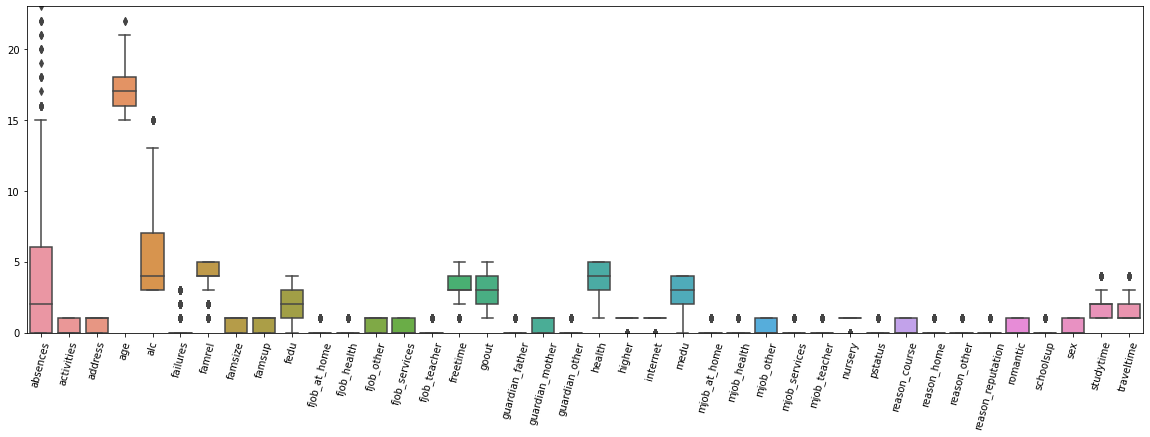

In [5]:
plt.figure(figsize=(20,6))
ax = sns.boxplot(data=dataset)
ax.set_xticklabels(ax.get_xticklabels(),rotation=75)
# celowo ucinam punkty oddalone z wykresu
ax.set_ylim(0,23);
#ax.set_yscale('log')

# 🍀 **Korelacje Cech**

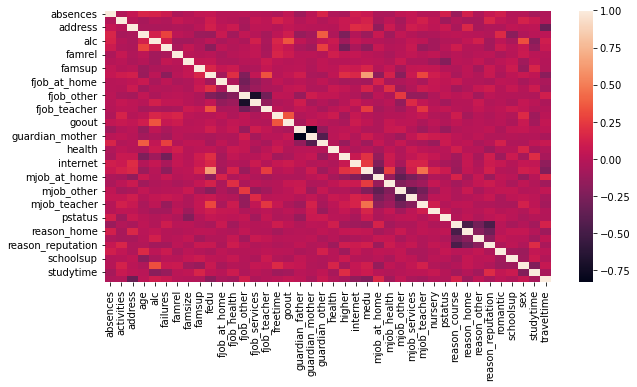

In [6]:
plt.figure(figsize=(10,5))
corr = dataset.corr()
sns.heatmap(data=corr);

In [7]:
corr_list = list(itertools.chain(*[[(r,c,corr.loc[r,c]) for r in corr.columns] for c in corr.columns]))
sorted_abs_corr_list = sorted(corr_list,key=lambda x:abs(x[2]), reverse=True)
sorted_abs_corr_list = list(filter(lambda x:x[0]!=x[1] and abs(x[2]) > 0.3, sorted_abs_corr_list))[::2]
pd.DataFrame(sorted_abs_corr_list, columns=['atr1','atr2','corr'])

,atr1,atr2,corr
0,guardian_mother,guardian_father,-0.830369
1,fjob_services,fjob_other,-0.711511
2,medu,fedu,0.637790
3,reason_home,reason_course,-0.477166
4,reason_reputation,reason_course,-0.467695
5,mjob_teacher,medu,0.450380
6,mjob_services,mjob_other,-0.430532
7,guardian_other,guardian_mother,-0.425006
8,mjob_at_home,medu,-0.380988
9,mjob_other,mjob_at_home,-0.379828


![title](https://miro.medium.com/max/932/1*Qz_gwy4ZaSZuOpl3IyO2HA.png)

Opis najbardziej znaczących korelacji:
- opieka ojca albo matki w rozwiedzionych parach
- edukacja matki i ojca
- praca nauczyciela i edukacja dla matek i ojców ale w mniejszym stopniu
- praca matki w domu, a wykształcenie
- tak zwany inny opiekun dla uczniów, których wiek jest nietypowo wysoki w szkole średniej (dom dziecka, etc.)
- wyjścia z domu, a alkohol i czas wolny
- czas podróży tym wyższy jeśli mieszają poza miastem
- płeć męska i alkohol
- wybór szkoły ze względu na reputację kontra ze względu na wygodę czyli bliskość od domu

# 🟡 **Skalowanie Danych**

In [8]:
# skalowanie minmax, nie wpływa na nasze atr. binarne, ale wyrównuje wpływ z pozostałymi atrybutami
scaler = MinMaxScaler()
dataset = pd.DataFrame(scaler.fit_transform(dataset), columns = dataset.columns)
# podział wyczyszczonego zbioru na części, wszystko robimy na treningowym (włącznie z walidacją), 
# a testowy dopiero na sam koniec dla już wybranego modelu
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=['alc']), dataset['alc'], test_size=0.2, random_state=1)

# 🟣 **Szukanie Modelu**
Przetestujemy następujące modele regresji:
- Multiple LinearRegression
- Ridge
- Lasso
- Elastic-Net
- SVR with kernel:

<ol>
<li>Poly</li>
<li>Linear</li>
<li>RBF</li>
</ol>

- Least Angle Regression

Na początku będę dobierał parametry na podstawie założonych apriori wartości pozostałych parametrów. Będzie to przypominać jedną iteracje prostej optymalizacji przestrzeni hiperparametrów (startującej w określonym wektorze początkowym hiperparametrów), ale z wieloma problemami (może kiedyś napiszę algorytm takiej optymalizacji rozwiązując problem poruszania się po skośnych drogach w krajobrazie optymalizacyjnym, ale na chwilę obecną będzie to służyć pewnemu porównaniu). Wykresy pomogą mi później wybrać zakresy wartości do przeszukiwania kombinacji hp. Następnie porównam oba podejścia, ale pierwsze służy głównie stworzeniu pewnego zrozumienia doboru hp. 

In [9]:
best_models = []

# Wieloraka Regresja Liniowa
Nie posiada żadnych hiperparametrów.

In [55]:
model = LinearRegression()
score = test_model(model,X_train,y_train,X_test,y_test)
best_models.append((model,score))
print(score)

0.14535861545138887


# Regresja Grzbietowa

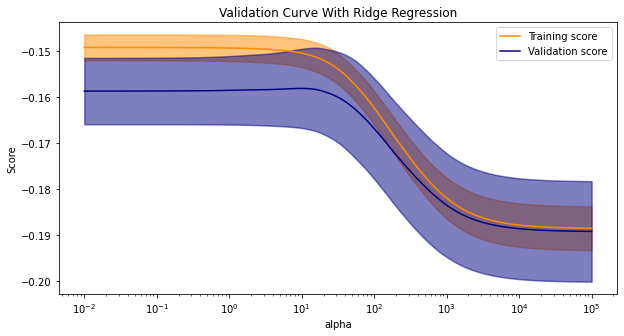

Best Parameter = 9.326033468832199 And Best Score = -0.15816275851306116


In [14]:
alpha, best_score, _,_ = plot_validation_curve(
    model = Ridge(random_state=1),
    model_name = "Ridge Regression",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-2,5,100),
    param_name = "alpha",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [56]:
model = Ridge(random_state=1,alpha=alpha)
score = test_model(model,X_train,y_train,X_test,y_test)
best_models.append((model,score))
print(score)

0.145983434458392


In [16]:
model = Ridge(random_state=1, alpha=alpha).fit(X_train,y_train)
dict(sorted(zip(X_train.columns,model.coef_),key=lambda x:abs(x[1]),reverse=True))

{'goout': 0.23122034409599285,
 'sex': 0.13180447901442557,
 'famrel': -0.1204352533603944,
 'absences': 0.09721728023403789,
 'age': 0.07609609790684646,
 'mjob_health': -0.06315333634242208,
 'studytime': -0.05729301809418237,
 'fjob_services': 0.052314341623419795,
 'fjob_teacher': -0.0503546032647889,
 'nursery': -0.043978366163198994,
 'reason_other': 0.03979783330634302,
 'health': 0.03898902620381432,
 'mjob_teacher': 0.03450001174111909,
 'traveltime': 0.033202047786510126,
 'famsize': -0.0329989683626177,
 'fedu': 0.02976795777458421,
 'fjob_at_home': -0.02737339932712497,
 'reason_reputation': -0.02610046051110421,
 'address': -0.024729738476890018,
 'guardian_mother': -0.024451602067916692,
 'reason_course': -0.024082874010289683,
 'romantic': 0.022658225052051922,
 'fjob_health': 0.022391793226815636,
 'mjob_services': 0.02202044656488441,
 'activities': -0.021035533914273603,
 'internet': 0.017840733461515348,
 'mjob_at_home': 0.013225335916304301,
 'guardian_father': 0.01

# Regresja Lasso

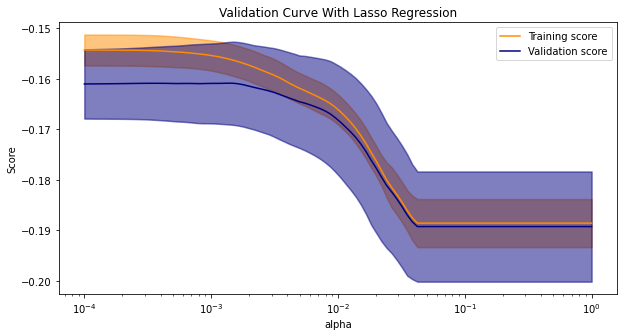

Best Parameter = 0.0013530477745798076 And Best Score = -0.16089701647532953


In [17]:
alpha, best_score, _,_ = plot_validation_curve(
    model = Lasso(random_state=1,positive=True),
    model_name = "Lasso Regression",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-4,0,100),
    param_name = "alpha",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [57]:
model = Lasso(random_state=1,positive=True,alpha=alpha)
score = test_model(model,X_train,y_train,X_test,y_test)
best_models.append((model,score))
print(score)

0.1513868251996525


In [19]:
model = Lasso(random_state=1,positive=True,alpha=alpha).fit(X_train,y_train)
dict(sorted(zip(X_train.columns,model.coef_),key=lambda x:abs(x[1]),reverse=True))

{'goout': 0.24083629635641732,
 'sex': 0.14183766577173787,
 'absences': 0.1288053352263616,
 'age': 0.07745848030419884,
 'fjob_services': 0.059622037562760015,
 'reason_other': 0.05725476551023088,
 'traveltime': 0.03893336845291585,
 'reason_home': 0.028035972842219856,
 'guardian_father': 0.02658071396383848,
 'health': 0.025466580946860058,
 'guardian_other': 0.023819418861079664,
 'mjob_services': 0.0210512617943896,
 'mjob_teacher': 0.018888706526809625,
 'mjob_at_home': 0.015927749075317434,
 'romantic': 0.014995222253848658,
 'fjob_other': 0.011788143193287704,
 'failures': 0.010117672685547014,
 'activities': 0.0,
 'address': 0.0,
 'famrel': 0.0,
 'famsize': 0.0,
 'famsup': 0.0,
 'fedu': 0.0,
 'fjob_at_home': 0.0,
 'fjob_health': 0.0,
 'fjob_teacher': 0.0,
 'freetime': 0.0,
 'guardian_mother': 0.0,
 'higher': 0.0,
 'internet': 0.0,
 'medu': 0.0,
 'mjob_health': 0.0,
 'mjob_other': 0.0,
 'nursery': 0.0,
 'pstatus': 0.0,
 'reason_course': 0.0,
 'reason_reputation': 0.0,
 'schoo

# Elastic-Net
- alpha
- l1_ratio

In [55]:
l1_ratio = 0.5

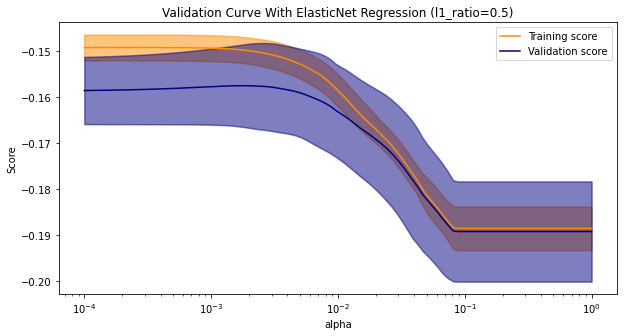

Best Parameter = 0.001788649529057435 And Best Score = -0.1575505946002494


In [61]:
alpha, best_score, _,_ = plot_validation_curve(
    model = ElasticNet(random_state=1,l1_ratio=l1_ratio),
    model_name = f"ElasticNet Regression (l1_ratio={l1_ratio})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-4,0,100),
    param_name = "alpha",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

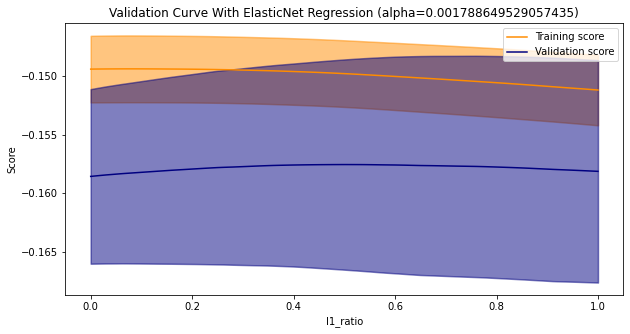

Best Parameter = 0.5 And Best Score = -0.1575505946002494


In [62]:
l1_ratio, best_score, _,_ = plot_validation_curve(
    model = ElasticNet(random_state=1,alpha=alpha),
    model_name = f"ElasticNet Regression (alpha={alpha})",
    X = X_train,
    y = y_train,
    param_range = np.arange(0,1.01,0.01),
    param_name = "l1_ratio",
    scoring = "neg_mean_absolute_error",
    xscale = "lin"
)

In [63]:
model = ElasticNet(random_state=1,alpha=alpha,l1_ratio=l1_ratio)
score = test_model(model,X_train,y_train,X_test,y_test)
best_models.append((model,score))
print(score)

0.14610229056658594


In [66]:
model = ElasticNet(random_state=1)

param_grid = {"alpha": np.logspace(-4,0,10),
              "l1_ratio": np.arange(0,1.01,0.1)}

search = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=2
).fit(X_train,y_train)

print(search.best_params_)

model = ElasticNet(random_state=1,**search.best_params_)
score = test_model(model,X_train,y_train,X_test,y_test)

print(score)

Fitting 5 folds for each of 110 candidates, totalling 550 fits
[CV] END .........................alpha=0.0001, l1_ratio=0.0; total time=   0.0s
[CV] END .........................alpha=0.0001, l1_ratio=0.0; total time=   0.0s
[CV] END .........................alpha=0.0001, l1_ratio=0.0; total time=   0.0s
[CV] END .........................alpha=0.0001, l1_ratio=0.0; total time=   0.0s
[CV] END .........................alpha=0.0001, l1_ratio=0.0; total time=   0.0s
[CV] END .........................alpha=0.0001, l1_ratio=0.1; total time=   0.0s
[CV] END .........................alpha=0.0001, l1_ratio=0.1; total time=   0.0s
[CV] END .........................alpha=0.0001, l1_ratio=0.1; total time=   0.0s
[CV] END .........................alpha=0.0001, l1_ratio=0.1; total time=   0.0s
[CV] END .........................alpha=0.0001, l1_ratio=0.1; total time=   0.0s
[CV] END .........................alpha=0.0001, l1_ratio=0.2; total time=   0.0s
[CV] END .........................alpha=0.0001

# SVM Z Jądrem Wielomianowym

- degree
- gamma
- C
- epsilon

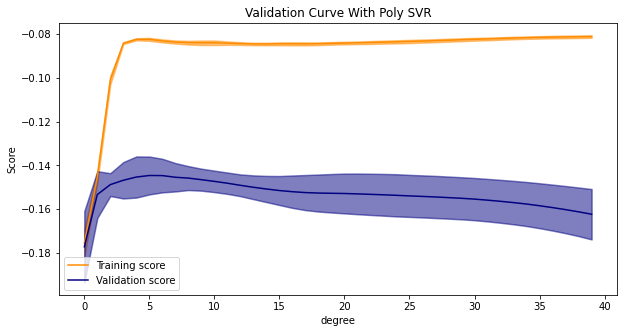

Best Parameter = 5 And Best Score = -0.1446530626581825


In [67]:
degree, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="poly"),
    model_name = "Poly SVR",
    X = X_train,
    y = y_train,
    param_range = np.arange(0,40),
    param_name = "degree",
    scoring = "neg_mean_absolute_error",
    xscale = "lin"
)

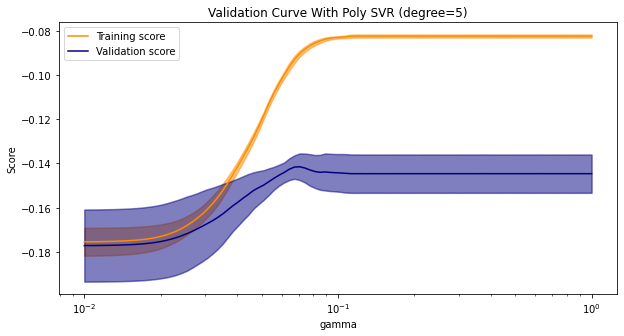

Best Parameter = 0.07054802310718646 And Best Score = -0.14150871572361923


In [68]:
gamma, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="poly",degree=degree),
    model_name = f"Poly SVR (degree={degree})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-2,0,100),
    param_name = "gamma",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

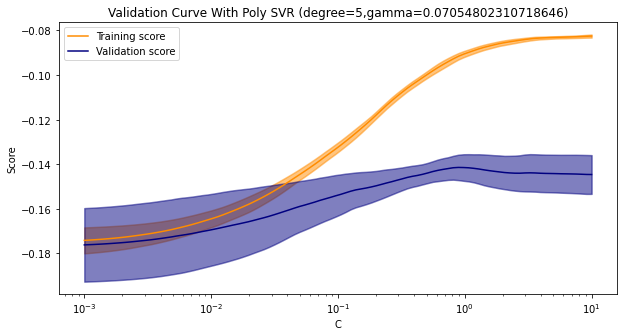

Best Parameter = 0.8902150854450392 And Best Score = -0.14145289825003185


In [69]:
C, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="poly",degree=degree,gamma=gamma),
    model_name = f"Poly SVR (degree={degree},gamma={gamma})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-3,1,100),
    param_name = "C",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

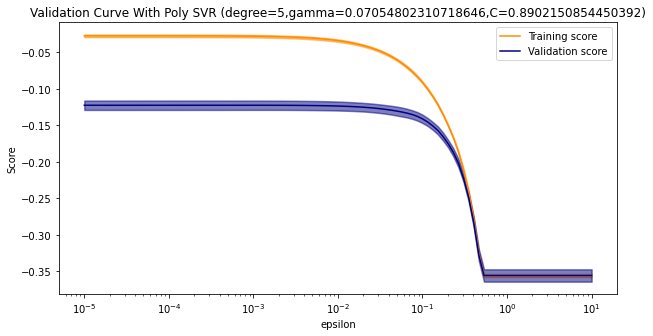

Best Parameter = 0.0002477076355991711 And Best Score = -0.12284854493091482


In [70]:
epsilon, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="poly",degree=degree,gamma=gamma,C=C),
    model_name = f"Poly SVR (degree={degree},gamma={gamma},C={C})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-5,1,100),
    param_name = "epsilon",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [77]:
model = SVR(kernel="poly",degree=degree,gamma=gamma,C=C,epsilon=epsilon).fit(X_train,y_train)
score = test_model(model,X_train,y_train,X_test,y_test)
best_models.append((model,score))
print(score)

0.11151307189445188


In [76]:
model = SVR(kernel="poly")

param_grid = {"degree": list(range(10)),
              "gamma": np.logspace(-1.5,-1,5),
              "C" : np.logspace(-0.5,0.5,5), 
              "epsilon" : np.logspace(-5,-1,5)
              }

search = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=2
).fit(X_train,y_train)

print(search.best_params_)

model = SVR(kernel="poly",**search.best_params_)
score = test_model(model,X_train,y_train,X_test,y_test)

print(score)

Fitting 5 folds for each of 1250 candidates, totalling 6250 fits
[CV] END C=0.31622776601683794, degree=0, epsilon=1e-05, gamma=0.03162277660168379; total time=   0.0s
[CV] END C=0.31622776601683794, degree=0, epsilon=1e-05, gamma=0.03162277660168379; total time=   0.0s
[CV] END C=0.31622776601683794, degree=0, epsilon=1e-05, gamma=0.03162277660168379; total time=   0.0s
[CV] END C=0.31622776601683794, degree=0, epsilon=1e-05, gamma=0.03162277660168379; total time=   0.0s
[CV] END C=0.31622776601683794, degree=0, epsilon=1e-05, gamma=0.03162277660168379; total time=   0.0s
[CV] END C=0.31622776601683794, degree=0, epsilon=1e-05, gamma=0.042169650342858224; total time=   0.0s
[CV] END C=0.31622776601683794, degree=0, epsilon=1e-05, gamma=0.042169650342858224; total time=   0.0s
[CV] END C=0.31622776601683794, degree=0, epsilon=1e-05, gamma=0.042169650342858224; total time=   0.0s
[CV] END C=0.31622776601683794, degree=0, epsilon=1e-05, gamma=0.042169650342858224; total time=   0.0s
[CV]

# SVM Z Jądrem Liniowym

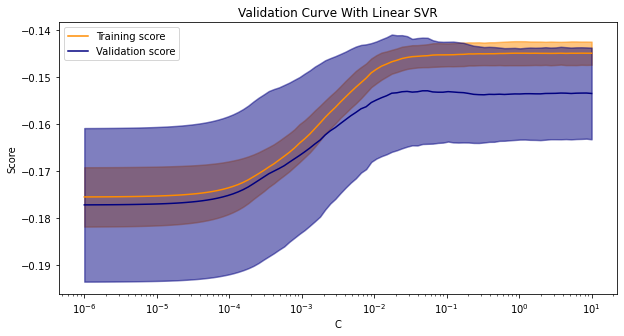

Best Parameter = 0.05462277217684337 And Best Score = -0.1530053740842049


In [79]:
C, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="linear"),
    model_name = "Linear SVR",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-6,1,100),
    param_name = "C",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

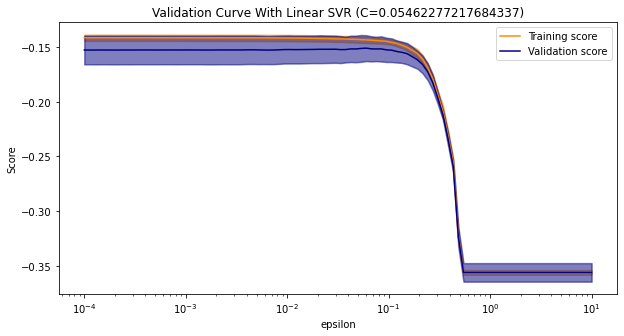

Best Parameter = 0.05994842503189409 And Best Score = -0.15137532650621635


In [80]:
epsilon, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="linear",C=C),
    model_name = f"Linear SVR (C={C})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-4,1,100),
    param_name = "epsilon",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [60]:
model = SVR(kernel="linear",C=C,epsilon=epsilon)
score = test_model(model,X_train,y_train,X_test,y_test)
best_models.append((model,score))
print(score)

0.14046590170011428


In [83]:
model = SVR(kernel="linear")

param_grid = {"C" : np.logspace(-3,0,20), 
              "epsilon" : np.logspace(-4,-1,20)}

search = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=2
).fit(X_train,y_train)

print(search.best_params_)

model = SVR(kernel="linear",**search.best_params_)
score = test_model(model,X_train,y_train,X_test,y_test)

print(score)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
[CV] END ............................C=0.001, epsilon=0.0001; total time=   0.0s
[CV] END ............................C=0.001, epsilon=0.0001; total time=   0.0s
[CV] END ............................C=0.001, epsilon=0.0001; total time=   0.0s
[CV] END ............................C=0.001, epsilon=0.0001; total time=   0.0s
[CV] END ............................C=0.001, epsilon=0.0001; total time=   0.0s
[CV] END .............C=0.001, epsilon=0.0001438449888287663; total time=   0.0s
[CV] END .............C=0.001, epsilon=0.0001438449888287663; total time=   0.0s
[CV] END .............C=0.001, epsilon=0.0001438449888287663; total time=   0.0s
[CV] END .............C=0.001, epsilon=0.0001438449888287663; total time=   0.0s
[CV] END .............C=0.001, epsilon=0.0001438449888287663; total time=   0.0s
[CV] END ............C=0.001, epsilon=0.00020691380811147902; total time=   0.0s
[CV] END ............C=0.001, epsilon=0.00020

# SVM Z Jądrem RBF

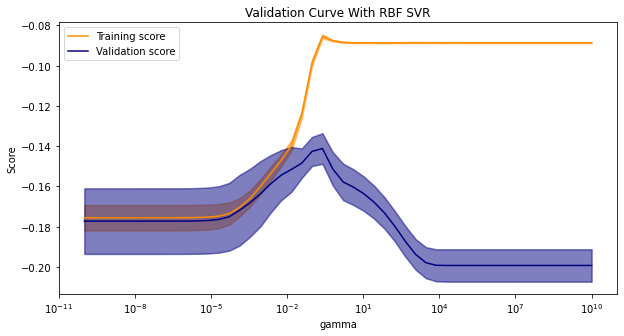

Best Parameter = 0.2442053094548655 And Best Score = -0.14115182224567357


In [31]:
gamma, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="rbf"),
    model_name = "RBF SVR",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-10,10,50),
    param_name = "gamma",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

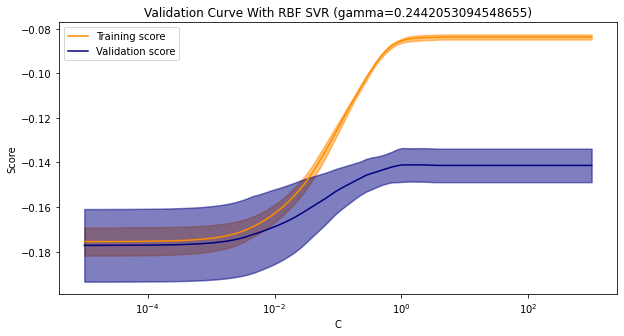

Best Parameter = 1.4849682622544667 And Best Score = -0.14109937651148824


In [32]:
C, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="rbf",gamma=gamma),
    model_name = f"RBF SVR (gamma={gamma})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-5,3,100),
    param_name = "C",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

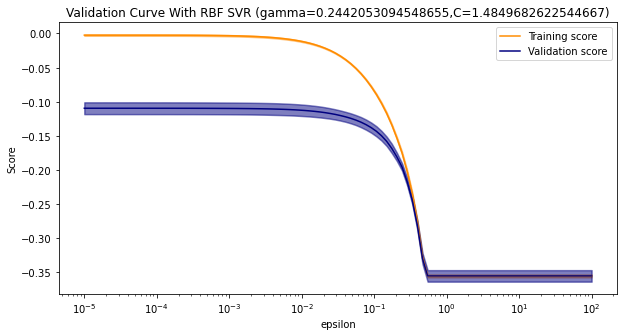

Best Parameter = 1.917910261672489e-05 And Best Score = -0.10968534672439845


In [33]:
epsilon, best_score, _,_ = plot_validation_curve(
    model = SVR(kernel="rbf",gamma=gamma,C=C),
    model_name = f"RBF SVR (gamma={gamma},C={C})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-5,2,100),
    param_name = "epsilon",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [61]:
model = SVR(kernel="rbf",gamma=gamma,C=C,epsilon=epsilon)
score = test_model(model,X_train,y_train,X_test,y_test)
best_models.append((model,score))
print(score)

0.09724484986284004


In [85]:
model = SVR(kernel="rbf")

param_grid = {"gamma" : np.logspace(-3,1,10), 
              "C" : np.logspace(-1,1,10),
              "epsilon" : np.logspace(-5,-2,10)}

search = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=2
).fit(X_train,y_train)

print(search.best_params_)

model = SVR(kernel="rbf",**search.best_params_)
score = test_model(model,X_train,y_train,X_test,y_test)

print(score)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV] END ..................C=0.1, epsilon=1e-05, gamma=0.001; total time=   0.0s
[CV] END ..................C=0.1, epsilon=1e-05, gamma=0.001; total time=   0.0s
[CV] END ..................C=0.1, epsilon=1e-05, gamma=0.001; total time=   0.0s
[CV] END ..................C=0.1, epsilon=1e-05, gamma=0.001; total time=   0.0s
[CV] END ..................C=0.1, epsilon=1e-05, gamma=0.001; total time=   0.0s
[CV] END ..C=0.1, epsilon=1e-05, gamma=0.0027825594022071257; total time=   0.0s
[CV] END ..C=0.1, epsilon=1e-05, gamma=0.0027825594022071257; total time=   0.0s
[CV] END ..C=0.1, epsilon=1e-05, gamma=0.0027825594022071257; total time=   0.0s
[CV] END ..C=0.1, epsilon=1e-05, gamma=0.0027825594022071257; total time=   0.0s
[CV] END ..C=0.1, epsilon=1e-05, gamma=0.0027825594022071257; total time=   0.0s
[CV] END ...C=0.1, epsilon=1e-05, gamma=0.007742636826811269; total time=   0.0s
[CV] END ...C=0.1, epsilon=1e-05, gamma=0.00

# Least Angle Regression

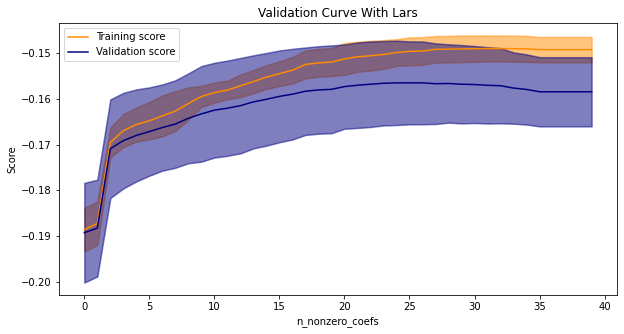

Best Parameter = 25 And Best Score = -0.15651081906343015


In [35]:
n_nonzero_coefs, best_score, _,_ = plot_validation_curve(
    model = Lars(random_state=1),
    model_name = "Lars",
    X = X_train,
    y = y_train,
    param_range = np.arange(0,len(X_train.columns)+1),
    param_name = "n_nonzero_coefs",
    scoring = "neg_mean_absolute_error",
    xscale = "lin"
)

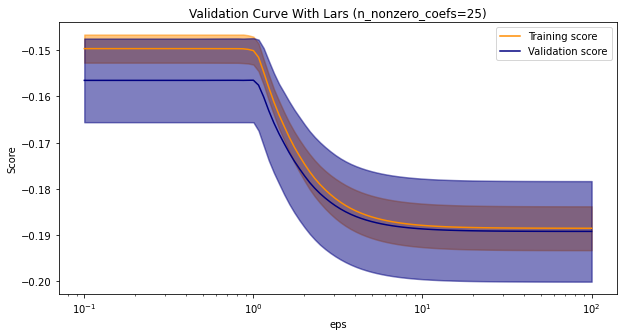

Best Parameter = 1.0 And Best Score = -0.15647653996335428


In [37]:
eps, best_score, _,_ = plot_validation_curve(
    model = Lars(random_state=1, n_nonzero_coefs=n_nonzero_coefs),
    model_name = f"Lars (n_nonzero_coefs={n_nonzero_coefs})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-1,2,100),
    param_name = "eps",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

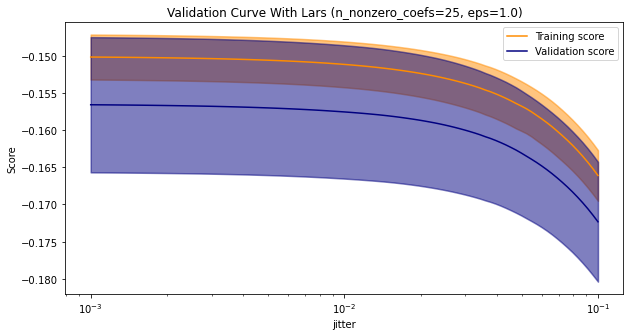

Best Parameter = 0.001 And Best Score = -0.15658054722676448


In [43]:
jitter, best_score, _,_ = plot_validation_curve(
    model = Lars(random_state=1, n_nonzero_coefs=n_nonzero_coefs, eps=eps),
    model_name = f"Lars (n_nonzero_coefs={n_nonzero_coefs}, eps={eps})",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-3,-1,100),
    param_name = "jitter",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [62]:
model = Lars(random_state=1,n_nonzero_coefs=n_nonzero_coefs,eps=eps,jitter=jitter)
score = test_model(model,X_train,y_train,X_test,y_test)
best_models.append((model,score))
print(score)

0.1448865662584298


In [87]:
model = Lars(random_state=1)

param_grid = {"n_nonzero_coefs" : list(range(20,30)), 
              "eps" : np.logspace(-1,0,10),
              "jitter" : np.logspace(-3,-2,5)}

search = GridSearchCV(
    model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=2
).fit(X_train,y_train)

print(search.best_params_)

model = Lars(random_state=1,**search.best_params_)
score = test_model(model,X_train,y_train,X_test,y_test)

print(score)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END ..........eps=0.1, jitter=0.001, n_nonzero_coefs=20; total time=   0.0s
[CV] END ..........eps=0.1, jitter=0.001, n_nonzero_coefs=20; total time=   0.0s
[CV] END ..........eps=0.1, jitter=0.001, n_nonzero_coefs=20; total time=   0.0s
[CV] END ..........eps=0.1, jitter=0.001, n_nonzero_coefs=20; total time=   0.0s
[CV] END ..........eps=0.1, jitter=0.001, n_nonzero_coefs=20; total time=   0.0s
[CV] END ..........eps=0.1, jitter=0.001, n_nonzero_coefs=21; total time=   0.0s
[CV] END ..........eps=0.1, jitter=0.001, n_nonzero_coefs=21; total time=   0.0s
[CV] END ..........eps=0.1, jitter=0.001, n_nonzero_coefs=21; total time=   0.0s
[CV] END ..........eps=0.1, jitter=0.001, n_nonzero_coefs=21; total time=   0.0s
[CV] END ..........eps=0.1, jitter=0.001, n_nonzero_coefs=21; total time=   0.0s
[CV] END ..........eps=0.1, jitter=0.001, n_nonzero_coefs=22; total time=   0.0s
[CV] END ..........eps=0.1, jitter=0.001, n_n

# 🟢 **Najlepsze Modele**
Wybrane ręcznie najlepsze modele.

In [73]:
best_models_sorted = dict(sorted(best_models, key=lambda x:x[1]))
best_models_sorted

{SVR(C=1.4849682622544667, epsilon=1.917910261672489e-05,
     gamma=0.2442053094548655): 0.09724484986284004,
 SVR(C=1.4849682622544667, degree=5, epsilon=1.917910261672489e-05,
     gamma=0.2442053094548655, kernel='poly'): 0.10676407813964849,
 SVR(C=1.4849682622544667, epsilon=1.917910261672489e-05, kernel='linear'): 0.14046590170011428,
 Lars(eps=1.0, jitter=0.001, n_nonzero_coefs=25, random_state=1): 0.1448865662584298,
 LinearRegression(): 0.14535861545138887,
 LinearRegression(): 0.14535861545138887,
 Ridge(alpha=0.001788649529057435, random_state=777): 0.145983434458392,
 ElasticNet(alpha=0.001788649529057435, random_state=1): 0.14610229056658594,
 Lasso(alpha=0.001788649529057435, positive=True, random_state=1): 0.1513868251996525}

# 🟠 **Wyniki W Dziedzinie Kategorii**
Z rozumienia zbioru danych wyłaniam 7 kategorii atrybutu opisywanego "alc": <br>
<ol>
<li>Prawie Wcale</li>
<li>Bardzo Mało</li>
<li>Mało</li>
<li>Średnio</li>
<li>Sporo</li>
<li>Dużo</li>
<li>Bardzo Dużo</li>
</ol>
Porówam najlepsze modele pod kątem ich wyników precision,recall,f1. 

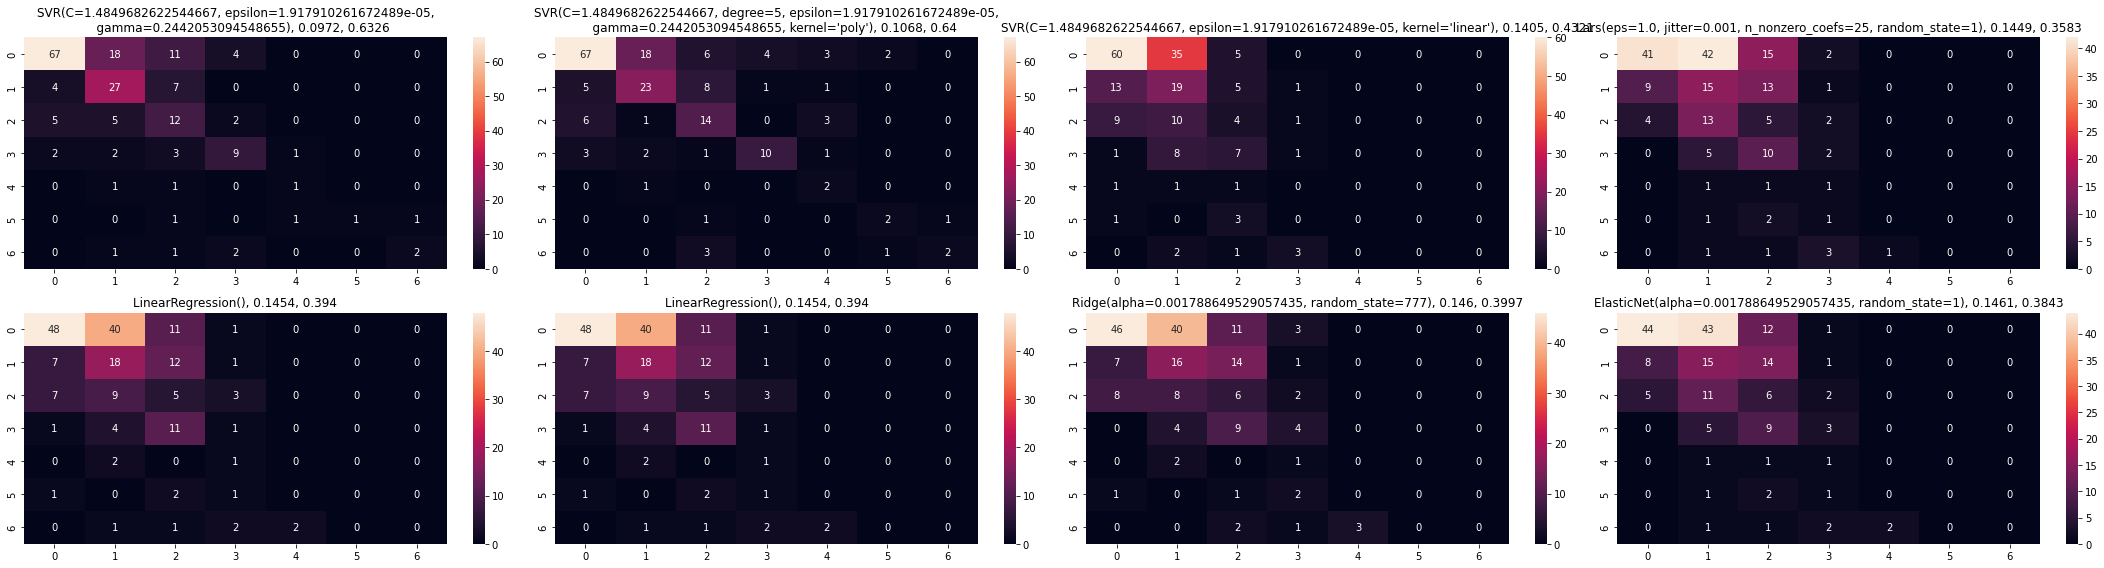

In [76]:
fig,axes = plt.subplots(2,4)
fig.set_figwidth(30)
fig.set_figheight(8)
for ax,model,mae in zip(list(itertools.chain(*axes)),best_models_sorted.keys(),best_models_sorted.values()):
    mae = round(mae,4)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    conf = confusion_matrix(*convert_to_categoricals(y_test,y_pred,7))
    f1 = round(f1_score(*convert_to_categoricals(y_test,y_pred,7), average="weighted"),4)
    ax.set_title(f"{model}, {mae}, {f1}")
    sns.heatmap(conf, annot=conf, ax=ax)
plt.tight_layout()

# 🔵 **Wnioski**
Najlepszy wynik udało się osiągnąć dla modelu SVR z jądrem Gaussa. Drugi również godny uwagi model SVR z jądrem wielomianowym. Błąd testowania najlepszego modelu wynosi około 0.096 co stanowi bardzo dobry wynik biorąc pod uwagę nasze dane. Bowiem błąd około 0.1 to połowa różnicy między kolejnymi stopniami alkoholizmu, więc wynik powinien być bardzo sensowny. W oryginalnych danych alkoholizm był określany w skali 1-5 (very low, low, avg, high, very high). Po przeskalowaniu na zakres 0-1, jednemu punktowi w skali odpowiada 0.2. Nasz błąd to około 0.1. Oznacza to, że nasz model nie myli się bardziej niż o pół stopnia w skali czyli np. kogoś kto pije mało zaklasyfikuje w najgorszym razie jako w połowie drogi do pijącego bardzo mało lub średnio. Największe błędy model osiąga dla osób, których warunki środowiskowe są bardzo trudne ale osoby te mają silny charakter i nie przesadzają z alkoholem pomimo trudnego życia (to bardzo optymistyczne :)). W dziedzinie kategorii nasz wybrany model również jest najlepszy i sądzę, że zadowalający. Trochę myli kategorie 0,1 czyli niepijących wcale z bardzo mało co jest zrozumiałe. Myli również bardzo mało z mało (1,2) i mało ze średnio (2,3). Jednak pamiętajny, że jest to problem regresji, a nie klasyfikacji. Poza tym często zdarzają sie dzieci ze świetnymi warunkami z bogatych domów, które marnują sobie życie i wpadają w kategorię ostatnią lub o wiele wyższą niż by się można spodziewać. Oczywiście i to możnaby uchwycić ale z większą liczbą atrybutów (lub innymi, bardziej psychologicznymi), ponieważ alkoholizm również ma podłoże psychologiczne, którego nasze atrybuty nie badają tak dokładnie. Ciekawe wyniki mógłby dać model uczony na danych rozszerzonych o właśnie psychologiczne.